In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

import eda 
import clf

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## DATA:

In [3]:
df_tr = pd.read_csv('df_CCF_tr.csv')
df_val = pd.read_csv('df_CCF_val.csv')
df_ts = pd.read_csv('df_CCF_ts.csv')

tr_val = [df_tr, df_val]

df_tr.shape, df_val.shape, df_ts.shape

((170884, 31), (56961, 31), (56962, 31))

### SPLITTING SMALLER DATA INTO TRAIN, VAL AND TEST SETS:

In [4]:
df_smaller = pd.read_csv('df_smaller_logreg.csv')
df_smaller.shape

(17536, 31)

In [5]:
y_idx_prior, y_idx_post = 0, 0

df_tr_smaller, df_val_smaller, df_ts_smaller = eda.fn_tr_val_ts_split(df_smaller, y_idx_prior)
tr_val_smaller = [df_tr_smaller, df_val_smaller]

df_tr_smaller.shape, df_val_smaller.shape, df_ts_smaller.shape

((10521, 31), (3507, 31), (3508, 31))

In [6]:
df_tr_smaller.head(2)

,y,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
11320,0,-0.791692,-0.020892,0.321802,0.547437,0.774527,-0.230284,0.900716,-1.082496,-2.011925,...,0.965258,-1.639280,0.825030,-0.581420,-1.629710,1.942333,-0.018420,0.328074,0.741026,-0.114136
9663,0,-0.351712,-0.384131,-0.058939,1.755065,0.855793,-0.791530,0.939764,-0.013022,0.434950,...,0.125406,0.196821,0.929974,0.240068,0.148245,-0.515558,-0.601378,0.497078,0.510052,0.196417


### TRAIN NEW LOG REG MODEL ON SMALLER DATASET:

In [7]:
C = [10**i for i in np.linspace(-6, -3, 10)]

param_dict = dict(penalty = ['l2'],
                            C = C,
                       solver = ['lbfgs'],
                 class_weight = ['balanced'],
                     max_iter = [600])
param_grid = clf.fn_param_grid(param_dict)

len(param_grid)

10

In [8]:
from sklearn.linear_model import LogisticRegression

model_class = LogisticRegression
df_Xy = df_tr_smaller

trained_models = clf.fn_train_models(df_Xy, model_class, param_dict)
len(trained_models)

100% |########################################################################|


10

### EVALUATE LOG REG MODEL FOR SMALLER DATA:

'successful'

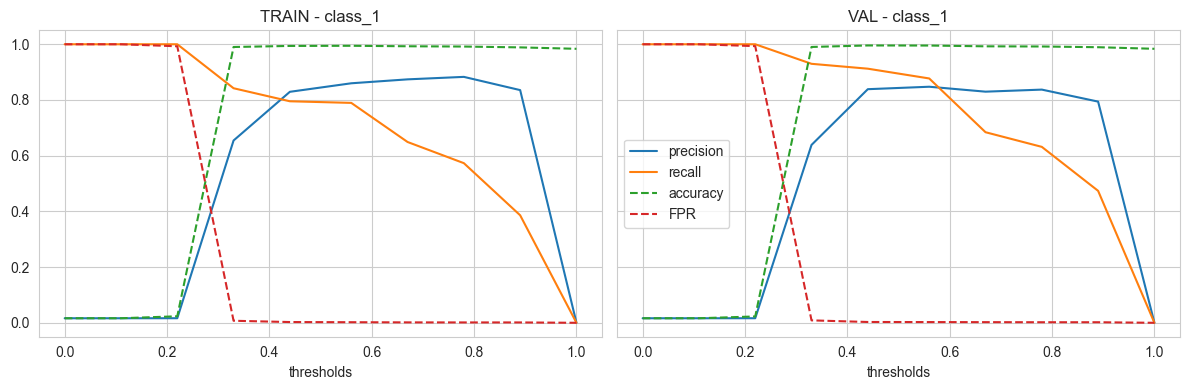

In [9]:
model_n = 4
trained_model = trained_models[model_n]

tr_val_smaller = tr_val_smaller

clf.fn_model_curves(trained_model, tr_val_smaller)

'successful'

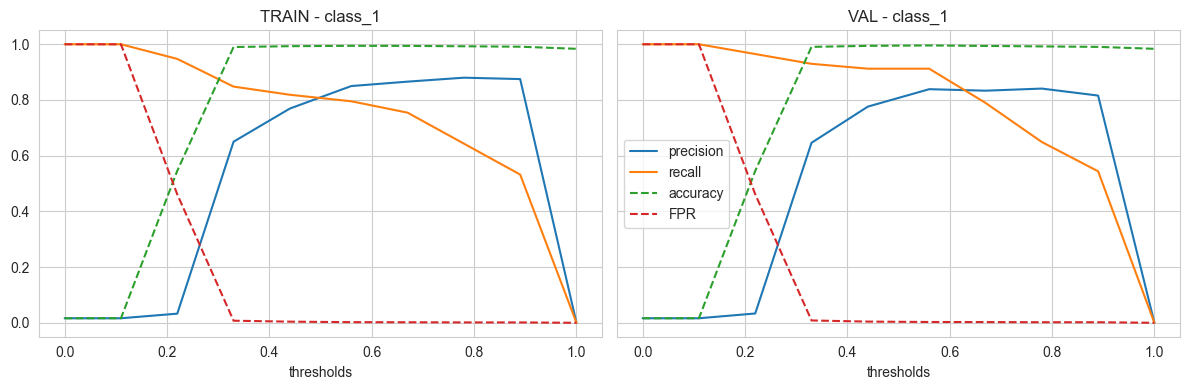

In [10]:
model_n = 5
trained_model = trained_models[model_n]

clf.fn_model_curves(trained_model, tr_val_smaller)

'successful'

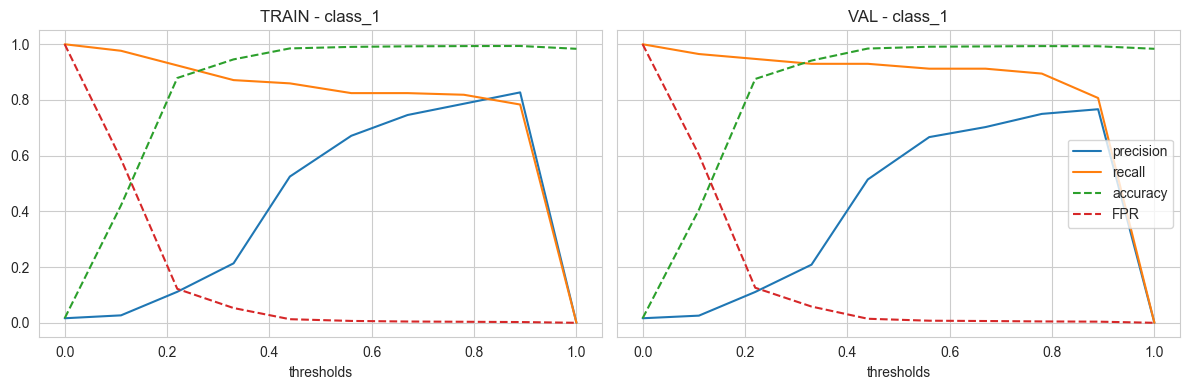

In [11]:
model_n = 9
trained_model = trained_models[model_n]

clf.fn_model_curves(trained_model, tr_val_smaller)

### TESTING PERFORMANCE OF SMALLER LOG REG MODEL:
**(WE CHOOSE MODEL 5 AND USE A PREDICTION THRESHOLD OF 0.55)

In [12]:
df_Xy = df_tr_smaller

trained_model = trained_models[5]
threshold = 0.55

y_pred_tr_smaller = clf.fn_test_model_binary_clf(df_Xy, trained_model, 
                                         threshold_class_1 = threshold)

-------------------------------------
LOGLOSS : 0.2635
ACCURACY: 0.994
-------------------------------------
          prec    rec  f1_score
class_0  99.66  99.77    99.715
class_1  85.00  79.53    82.174


In [13]:
df_Xy = df_ts_smaller

y_pred_ts_smaller = clf.fn_test_model_binary_clf(df_Xy, trained_model, 
                                         threshold_class_1 = threshold)

-------------------------------------
LOGLOSS : 0.2677
ACCURACY: 0.994
-------------------------------------
          prec    rec  f1_score
class_0  99.62  99.77    99.695
class_1  84.62  77.19    80.734


### SAVE MODEL TRAINED ON SMALLER DATA:

In [ ]:
#-----   dump(trained_models[5], 'model_small_logreg.joblib') 

### TESTING PERFORMANCE OF COMBINED MODEL:

In [14]:
model_big = load('model_big_logreg.joblib')
model_small = load('model_small_logreg.joblib')

In [15]:
def fn_predict_pipeline(df_Xy, model_big, model_small, thresh_big, thresh_small):

    y_pred_model_big = clf.fn_predict_binary_clf(df_Xy, model_big, threshold_class_1 = thresh_big)    

    df_Xy_smaller = df_Xy[y_pred_model_big == 1]
    y_pred_model_small = clf.fn_predict_binary_clf(df_Xy_smaller, model_small, threshold_class_1 = thresh_small)

    y_pred_model_big_0_idxs = y_pred_model_big[y_pred_model_big == 0].index
    y_pred_model_small_0_idxs = y_pred_model_small[y_pred_model_small == 0].index
    y_pred_0_idxs = np.array(list(y_pred_model_big_0_idxs) + list(y_pred_model_small_0_idxs))
    y_pred_0 = pd.Series([0 for i in range(len(y_pred_0_idxs))], index = y_pred_0_idxs)

    y_pred_1_idxs = y_pred_model_small[y_pred_model_small == 1].index
    y_pred_1 = pd.Series([1 for i in range(len(y_pred_1_idxs))], index = y_pred_1_idxs)

    y_pred = pd.concat([y_pred_0, y_pred_1])

    df_y = pd.DataFrame().assign(y = df_Xy.y, y_pred = y_pred)
    df_y_pos = df_y[df_y.y == 1]
    df_y_neg = df_y[df_y.y == 0]

    recall_1 = round(df_y_pos.y_pred.sum()/len(df_y_pos), 4)
    precision_1 = round(df_y_pos.y_pred.sum()/len(y_pred_1), 4)
    recall_0 = round(len(df_y_neg[df_y_neg.y_pred == 0])/len(df_y_neg), 4)
    precision_0 = round(len(df_y_neg[df_y_neg.y_pred == 0])/len(y_pred_0), 4)

    dff = pd.DataFrame().assign(precision = [precision_0, precision_1], recall = [recall_0, recall_1])
    dff.index = 'class_0 class_1'.split()
    dff['f1 score'] = 2*dff.recall*dff.precision/(dff.recall+dff.precision)

    acc = round(len(df_y[df_y.y == df_y.y_pred])/len(df_y), 4)*100
    print('-----------------------')
    print(f'accuracy: {acc}')
    print('-----------------------')


    return dff.round(4)*100

In [16]:
df_Xy = df_tr

thresh_big = 0.2
thresh_small = 0.55

fn_predict_pipeline(df_Xy, model_big, model_small, thresh_big, thresh_small)

-----------------------
accuracy: 99.94
-----------------------


,precision,recall,f1 score
class_0,99.96,99.98,99.97
class_1,84.67,78.64,81.54


In [17]:
df_Xy = df_val

fn_predict_pipeline(df_Xy, model_big, model_small, thresh_big, thresh_small)

-----------------------
accuracy: 99.94
-----------------------


,precision,recall,f1 score
class_0,99.97,99.98,99.97
class_1,84.95,80.61,82.72


In [18]:
df_Xy = df_ts

fn_predict_pipeline(df_Xy, model_big, model_small,thresh_big, thresh_small)

-----------------------
accuracy: 99.95
-----------------------


,precision,recall,f1 score
class_0,99.96,99.99,99.97
class_1,90.59,77.78,83.70
